## Deep Learning for Text Classification & QA
#### This program originates from the tutorial of tensorflow: https://www.tensorflow.org/tutorials/keras/basic_text_classification
####  Based on the needs of study, the following modifications are made:
1. Tries the different embedding approaches: word2vec, glovec.<br />
2. Apply RNN, GRU, LSTM to compare the accuracy and efforts of algorithms. <br />

In addition, the source file in this program was not uploaded, and the audience can create your own by MS excel file, in which, 2 columns, one for input question ( Data x), and one for label ( Data y).

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [96]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding,LSTM,Flatten,GRU
from keras.preprocessing import text, sequence
from keras import utils

import gensim
from gensim.models import Word2Vec
from gensim.models import FastText

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 1.12.0


### Load the mock dataset

In [3]:
source = pd.read_excel('../98_data/mail_groupby2.xlsx', encoding='latin-1')
source.head()

,convid,subject,length,tousflag,dialognm,forwardtime,imagenm,notimagenm,mailbody,mailquestion,imagetype,firstanswername,firstforwardname,Category
0,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,NaN,26.500000,1,3.0,1,0,0,now personname change target date and able to ...,i can not find anything related to this after ...,NaN,yosong@abeam.com,yosong@abeam.com,Timesheet
1,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,NaN,14.333333,0,2.0,0,0,0,from date from date 9 9 9 9 nasa file expense ...,the from date property in the expense module f...,NaN,NaN,NaN,non-issue
2,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,NaN,85.000000,0,1.0,0,0,0,a virus was detected in a message you have rec...,a virus was detected in a message you have rec...,NaN,NaN,NaN,non-issue
3,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,NaN,11.000000,0,1.0,0,0,0,please find user s question as below . kindly ...,please find user s question as below . kindly ...,NaN,NaN,NaN,non-issue
4,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,NaN,21.000000,1,1.5,0,0,0,we think it was caused by google bar in your b...,hi nasa team i had a problem which accessing t...,NaN,yosong@abeam.com,NaN,Authorization


In [4]:
# Rename the columns
df=source[['mailquestion','Category']]
df.columns=['Emails','Cat']
df = df[pd.notnull(df['Emails'])]
df.head()

,Emails,Cat
0,i can not find anything related to this after ...,Timesheet
1,the from date property in the expense module f...,non-issue
2,a virus was detected in a message you have rec...,non-issue
3,please find user s question as below . kindly ...,non-issue
4,hi nasa team i had a problem which accessing t...,Authorization


In [5]:
df.isnull().sum()

Emails    0
Cat       0
dtype: int64

In [6]:
df['Cat'].value_counts()

non-issue        362
Timesheet        285
Authorization     59
Others            15
Report             7
Project            5
Name: Cat, dtype: int64

In [60]:
# Split data into train and test
train_size = int(len(df) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 586
Test size: 147


### Convert the words to integers

In [61]:
train_narrative = df['Emails'][:train_size]
train_product = df['Cat'][:train_size]

test_narrative = df['Emails'][train_size:]
test_product = df['Cat'][train_size:]

In [62]:
# Find out the maximum words for the dimension of word vectors
def text2word(doc):
    """
    Usage: Convert one text into word list.
    Input: doc - string list
    Output: documents - string list: all sentences in words list.
            text_len - int: maximum numbers of words in one sentense
            max_text - strig list: the words list of the sentence with maximum words
    """
    return_docs=[]
    text_len=0
    max_text=''
    #for item in df['Emails']:
    for item in doc:
        text_words=[word for word in str(item).lower().split()]
        return_docs.append(text_words)
        if len(text_words)> text_len:
            text_len=len(text_words)
            max_text=text_words
    #max_words = text_len
    
    return return_docs,text_len,max_text

documents,max_words,_=text2word(df['Emails'])
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [63]:
tokenize.fit_on_texts(train_narrative) # only fit on train
x_train_o = tokenize.texts_to_matrix(train_narrative)
x_test_o = tokenize.texts_to_matrix(test_narrative)
word_index = tokenize.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2345 unique tokens.


In [64]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_product)
y_train_o = encoder.transform(train_product)
y_test_o = encoder.transform(test_product)

In [65]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train_o) + 1
y_train_o = utils.to_categorical(y_train_o, num_classes)
y_test_o = utils.to_categorical(y_test_o, num_classes)

In [66]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train_o.shape)
print('x_test shape:', x_test_o.shape)
print('y_train shape:', y_train_o.shape)
print('y_test shape:', y_test_o.shape)

x_train shape: (586, 925)
x_test shape: (147, 925)
y_train shape: (586, 6)
y_test shape: (147, 6)


## 1.  Model without embedding layer

### Build the model

In [67]:
# Open questions: why are those parameters used for?
batch_size = 5
epochs = 50

In [68]:
# Build the model
model = Sequential()
model.add(Dense(16, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a categorical classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the categorical_crossentropy loss function.
This isn't the only choice for a loss function, you could, for instance, choose mean_squared_error. But, generally, categorical_crossentropy is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.
Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.
Now, configure the model to use an optimizer and a loss function:

In [69]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Train the model

In [70]:
history = model.fit(x_train_o, y_train_o,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 468 samples, validate on 118 samples
Epoch 1/50
468/468 [==============================] - 1s 2ms/step - loss: 1.6706 - acc: 0.3996 - val_loss: 1.2110 - val_acc: 0.5932
Epoch 2/50
468/468 [==============================] - 0s 345us/step - loss: 1.4263 - acc: 0.4957 - val_loss: 1.0111 - val_acc: 0.6102
Epoch 3/50
468/468 [==============================] - 0s 292us/step - loss: 1.2599 - acc: 0.5726 - val_loss: 0.9539 - val_acc: 0.7119
Epoch 4/50
468/468 [==============================] - 0s 276us/step - loss: 1.1198 - acc: 0.6090 - val_loss: 0.8862 - val_acc: 0.7034
Epoch 5/50
468/468 [==============================] - 0s 258us/step - loss: 1.0701 - acc: 0.6239 - val_loss: 0.8653 - val_acc: 0.7458
Epoch 6/50
468/468 [==============================] - 0s 263us/step - loss: 1.0280 - acc: 0.6261 - val_loss: 0.8814 - val_acc: 0.7203
Epoch 7/50
468/468 [==============================] - 0s 256us/step - loss: 1.0108 - acc: 0.6346 - val_loss: 0.7927 - val_acc: 0.7458
Epoch 8/50
468/468

In [71]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test_o, y_test_o,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

147/147 [==============================] - 0s 147us/step
Test score: 1.053924291109552
Test accuracy: 0.6598639563232863


### Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [72]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

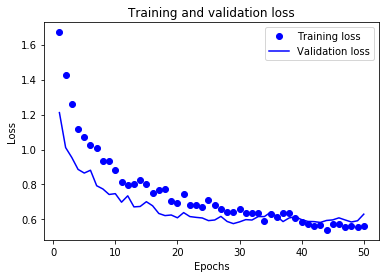

In [73]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

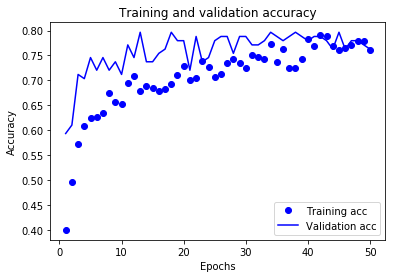

In [74]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.
Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.
This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.
For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.

### Evaluate model

#### Scenario 1: Verify 10 records in test dataset

In [22]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_narrative.iloc[i][:50], "...")
    print('Actual label:' + test_product.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

NameError: name 'x_test' is not defined

#### Scenario 2: Predict category based on manual input

In [23]:
input_sentence = ''
while(1):
    try:
        # Get input sentence
        input_sentence = input('> ')
        # Check if it is quit case
        if input_sentence == 'q' or input_sentence == 'quit': 
            break
        # Normalize sentence
        input_sentence = tokenize.texts_to_matrix([input_sentence])       
        pred_output = model.predict(np.array(input_sentence))
        pred_prob=model.predict_proba(np.array(input_sentence))
        predicted_label = text_labels[np.argmax(pred_output)]
        print('Bot:', ' '.join([predicted_label,'Probality:',str(pred_prob[0,np.argmax(pred_output)])]))
    except KeyError:
        print("Error: Encountered unknown word.")

> q


In [24]:
encoder.classes_

array(['Authorization', 'Others', 'Project', 'Report', 'Timesheet',
       'non-issue'], dtype=object)

## 2. Model with pre-trained embedding layer - Glove

In [75]:
MAX_SEQUENCE_LENGTH = max_words
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [76]:
embeddings_index = {}
f = open(os.path.join('../98_data/glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [77]:
#leverage embedding_index dictionary and word_index to compute our embedding matrix:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [78]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [79]:
# Build the model
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(16, activation='sigmoid'))
model.add(Dropout(0.8))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [80]:
batch_size = 5
epochs = 50
history = model.fit(x_train_o, y_train_o,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 468 samples, validate on 118 samples
Epoch 1/50
468/468 [==============================] - 2s 4ms/step - loss: 1.8362 - acc: 0.3868 - val_loss: 1.7215 - val_acc: 0.5593
Epoch 2/50
468/468 [==============================] - 1s 3ms/step - loss: 1.6700 - acc: 0.4829 - val_loss: 1.6208 - val_acc: 0.5593
Epoch 3/50
468/468 [==============================] - 1s 3ms/step - loss: 1.5469 - acc: 0.5470 - val_loss: 1.4926 - val_acc: 0.5678
Epoch 4/50
468/468 [==============================] - 1s 3ms/step - loss: 1.4610 - acc: 0.5491 - val_loss: 1.4723 - val_acc: 0.5678
Epoch 5/50
468/468 [==============================] - 1s 3ms/step - loss: 1.3853 - acc: 0.5791 - val_loss: 1.4198 - val_acc: 0.5678
Epoch 6/50
468/468 [==============================] - 1s 3ms/step - loss: 1.3536 - acc: 0.6026 - val_loss: 1.3338 - val_acc: 0.7288
Epoch 7/50
468/468 [==============================] - 1s 3ms/step - loss: 1.2452 - acc: 0.6154 - val_loss: 1.2649 - val_acc: 0.7458
Epoch 8/50
468/468 [==========

In [81]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test_o, y_test_o,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

147/147 [==============================] - 0s 495us/step
Test score: 0.9827404318212651
Test accuracy: 0.6258503508811094


In [82]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

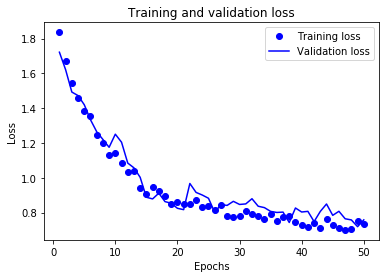

In [83]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

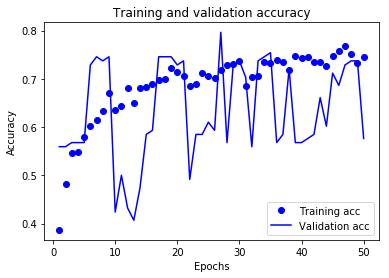

In [84]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 3. Model with pre-trained embedding layer - Word2Vec and FastText

In [ ]:
# training the model of word2vec by mail body
source_text=pd.DataFrame(data=pd.concat([source['mailbody'],source['mailquestion']]),columns=['mailbody'])
mb_sen,_,_=text2word(source_text['mailbody'])
model_embedding_w = Word2Vec(sentences=mb_sen, size=EMBEDDING_DIM, window=5, min_count=2, workers=4, sg=0)
#model_embedding_w = FastText(mb_sen, size=EMBEDDING_DIM, window=5, min_count=1, workers=4,sg=1)
model_embedding_w.train(mb_sen, total_examples=len(mb_sen), epochs=50)

In [46]:
#leverage embedding_index dictionary and word_index to compute our embedding matrix:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = model_embedding_w.wv.get_vector(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    except: 
        print(word, 'not found')

k not found
jan not found
aug not found
sep not found
feb not found
oct not found
09 not found


In [47]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [48]:
# Build the model
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(16, activation='sigmoid'))
model.add(Dropout(0.8))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [49]:
batch_size = 5
epochs = 50
history = model.fit(x_train_o, y_train_o,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 468 samples, validate on 118 samples
Epoch 1/50
468/468 [==============================] - 2s 4ms/step - loss: 1.5321 - acc: 0.4658 - val_loss: 1.1295 - val_acc: 0.5847
Epoch 2/50
468/468 [==============================] - 1s 2ms/step - loss: 1.2162 - acc: 0.5962 - val_loss: 0.9646 - val_acc: 0.5339
Epoch 3/50
468/468 [==============================] - 1s 3ms/step - loss: 1.1330 - acc: 0.5833 - val_loss: 1.0075 - val_acc: 0.5169
Epoch 4/50
468/468 [==============================] - 1s 3ms/step - loss: 1.1143 - acc: 0.6239 - val_loss: 1.1376 - val_acc: 0.4661
Epoch 5/50
468/468 [==============================] - 1s 2ms/step - loss: 1.0277 - acc: 0.6410 - val_loss: 1.0454 - val_acc: 0.4661
Epoch 6/50
468/468 [==============================] - 1s 2ms/step - loss: 0.9733 - acc: 0.6517 - val_loss: 0.9089 - val_acc: 0.7288
Epoch 7/50
468/468 [==============================] - 1s 2ms/step - loss: 0.9648 - acc: 0.6453 - val_loss: 0.9251 - val_acc: 0.6102
Epoch 8/50
468/468 [==========

In [50]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test_o, y_test_o,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

147/147 [==============================] - 0s 375us/step
Test score: 0.9911400596706235
Test accuracy: 0.6598639554109703


In [51]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

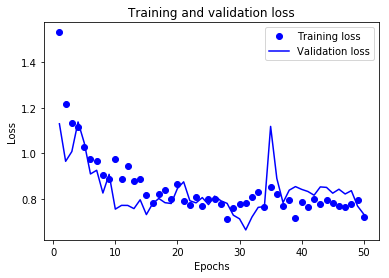

In [52]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

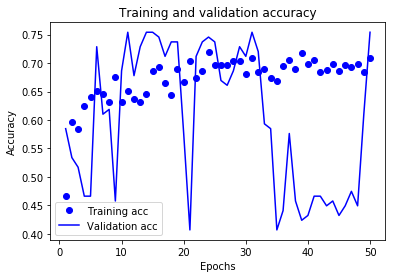

In [53]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4. LSTM, GRU with simple embedding layer

In [97]:
# Open questions: why are those parameters used for?
batch_size = 5
epochs = 10
# Build the model
model = Sequential()
model.add(Embedding(max_words, 128))
#model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(GRU(128,dropout=0.2))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [98]:
history = model.fit(x_train_o, y_train_o,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)


Train on 468 samples, validate on 118 samples
Epoch 1/10
468/468 [==============================] - 68s 146ms/step - loss: 1.2302 - acc: 0.5192 - val_loss: 0.8392 - val_acc: 0.5847
Epoch 2/10
468/468 [==============================] - 67s 144ms/step - loss: 1.1233 - acc: 0.5299 - val_loss: 0.8562 - val_acc: 0.5847
Epoch 3/10
468/468 [==============================] - 67s 142ms/step - loss: 1.1201 - acc: 0.5278 - val_loss: 0.8389 - val_acc: 0.5847
Epoch 4/10
468/468 [==============================] - 66s 141ms/step - loss: 1.1191 - acc: 0.5192 - val_loss: 0.8447 - val_acc: 0.5847
Epoch 5/10
468/468 [==============================] - 64s 137ms/step - loss: 1.1197 - acc: 0.5299 - val_loss: 0.8194 - val_acc: 0.5847
Epoch 6/10
468/468 [==============================] - 65s 139ms/step - loss: 1.1208 - acc: 0.5299 - val_loss: 0.8410 - val_acc: 0.5847
Epoch 7/10
468/468 [==============================] - 65s 139ms/step - loss: 1.1214 - acc: 0.5299 - val_loss: 0.8396 - val_acc: 0.5847
Epoch 8/1

In [92]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test_o, y_test_o,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

147/147 [==============================] - 4s 27ms/step
Test score: 1.188290801583504
Test accuracy: 0.3061224544534878


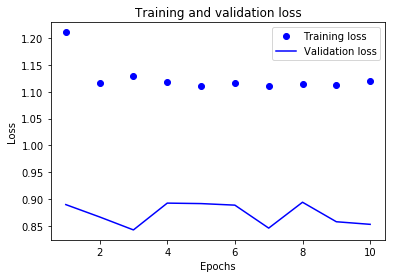

In [93]:
history_dict = history.history
history_dict.keys()
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

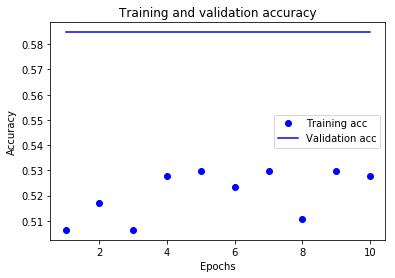

In [94]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()